In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

torch.set_printoptions(sci_mode = False)

# Convention

- The two input dimensions are called x1 and x2. In the general cartesian setting this is referred to as x and y.
- The two output dimensions, that jointly make up the velocity vector are referred to as y1 and y2. In other settings this is referred to as the u and v component of velocity. 
- Torch tensor are index from the top left corner (origin upper), but most vis tools start in the bottom left.

# Simulations

We want simulations that resemble realistic ice flux. We can choose three example of realistic settings.

# Divergence

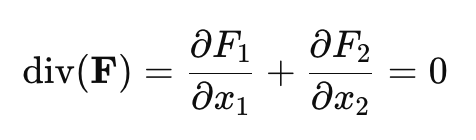

Notes:
- Issues with swirling (curl): Increase lengthscale
- Term: "solenoidal" covariance function
- Riesz kernel?!
- 2D incompressible flow (divergence-free)

# ToDo

- [ ] wrap in function
- [ ] compare to SE kernel
- [ ] make sampling work
- [ ] 2D
- [ ] why does it only with with the difference and not the absolute difference?!

# Function

Let#s retire this more complicated function:

## Curve

In [4]:
# curve
def input_output_function(X1, X2, a = 0.01):
    """Applies determinisitic function to input data.
    Works on 2D grid data or [N, 1] training data.

    Args:
        X1 (torch.Size([N_grid, N_grid])): X1 grid, or torch.Size([N_train, 1])
        X2 (torch.Size([N_grid, N_grid])): X2 grid or torch.Size([N_train, 1])
        a (float, optional): _description_. Defaults to a.

    Returns:
        Y1 (torch.Size([N_grid, N_grid])): Y1 grid
        Y2 (torch.Size([N_grid, N_grid])): Y2 grid
    """
    # 
    Y1 = X1
    Y2 = - X2
    # note: transpose output of np implementation
    return Y1, Y2

## Ridge

In [5]:
# ridge
# ridge is not divergence free
def ridge_input_output_function(X1, X2, a = 0.01):
    """Applies determinisitic function to input data.
    Works on 2D grid data or [N, 1] training data.

    Args:
        X1 (torch.Size([N_grid, N_grid])): X1 grid, or torch.Size([N_train, 1])
        X2 (torch.Size([N_grid, N_grid])): X2 grid or torch.Size([N_train, 1])
        a (float, optional): _description_. Defaults to a.

    Returns:
        Y1 (torch.Size([N_grid, N_grid])): Y1 grid
        Y2 (torch.Size([N_grid, N_grid])): Y2 grid
    """
    # 
    Y1 = X1
    Y2 = X1/X1
    #Y2 = torch.tensor(1.0)
    # note: transpose output of np implementation
    return Y1, Y2

## Funnel

The funnel is similar to Byrd glacier

In [20]:
def funnel_input_output_function(X1, X2, a = 0.01):
    """Applies determinisitic function to input data.
    Works on 2D grid data or [N, 1] training data.

    Args:
        X1 (torch.Size([N_grid, N_grid])): X1 grid, or torch.Size([N_train, 1])
        X2 (torch.Size([N_grid, N_grid])): X2 grid or torch.Size([N_train, 1])
        a (float, optional): _description_. Defaults to a.

    Returns:
        Y1 (torch.Size([N_grid, N_grid])): Y1 grid
        Y2 (torch.Size([N_grid, N_grid])): Y2 grid
    """

    # 
    Y1 = X2
    Y2 = X1
    # note: transpose output of np implementation
    return Y1, Y2

In [43]:
# N in x1 and x2 direction (square grid)
N_x = 20
N_grid = N_x * N_x

# vectors - torch.Size([20])
x1 = torch.linspace(0, 4, N_x)
x2 = torch.linspace(4, 0, N_x)

# generate two meshgrids
X1, X2 = torch.meshgrid(x1, x2)

### CALL FUNCTION ###
Y1, Y2 = funnel_input_output_function(X1, X2)

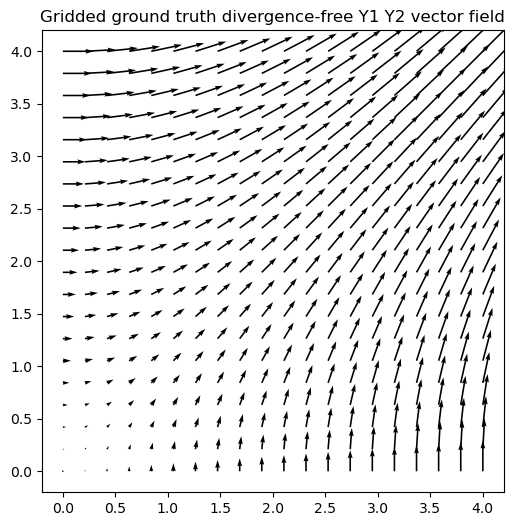

In [44]:
### PLOT ###
fig, ax = plt.subplots(figsize = (6, 6))

# fix quiver parameters for consistent visualisation across axis
quiver_width = 0.0035
quiver_scale = 60

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, Y1, Y2, color = 'black', width = quiver_width, scale = quiver_scale)

ax.set_aspect('equal')
plt.title('Gridded ground truth divergence-free Y1 Y2 vector field')
# noise free

plt.show()

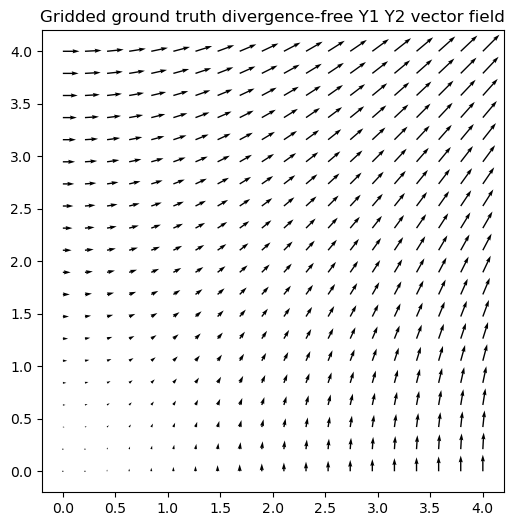

In [45]:
### PLOT ###
fig, ax = plt.subplots(figsize = (6, 6))

# fix quiver parameters for consistent visualisation across axis

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, Y1, Y2, color = 'black')

ax.set_aspect('equal')
plt.title('Gridded ground truth divergence-free Y1 Y2 vector field')
# noise free

plt.show()

### Check divergence free property

In [46]:
# np.gradient default step size is 1 but we want the actual step size of the grid
delta_x1, delta_x2 = X1[1, 0] - X1[0, 0], X2[0, 1] - X2[0, 0]

print(f"True spacing between grid values: ({delta_x1:.3f}, {delta_x2:.3f})")

# Ordering of axis is counter-intuitive!!!
divergence = np.gradient(Y1, delta_x1, axis = 0) + np.gradient(Y2, delta_x2, axis = 1)

# We are exacly reprocing matlab code
print("Highest abolute divergence value: ", np.max(np.abs(divergence)))
print("Highest abolute divergence value without outermost boarder: ", np.max(np.abs(divergence[1:-1, 1:-1])))
# symmetry: as a sum it is non divergent: cancelling out

print("Sum of all divergence values balances out to zero: ", np.sum(divergence))

True spacing between grid values: (0.211, -0.211)
Highest abolute divergence value:  0.0
Highest abolute divergence value without outermost boarder:  0.0
Sum of all divergence values balances out to zero:  0.0


In the following example I revered the y-axis.

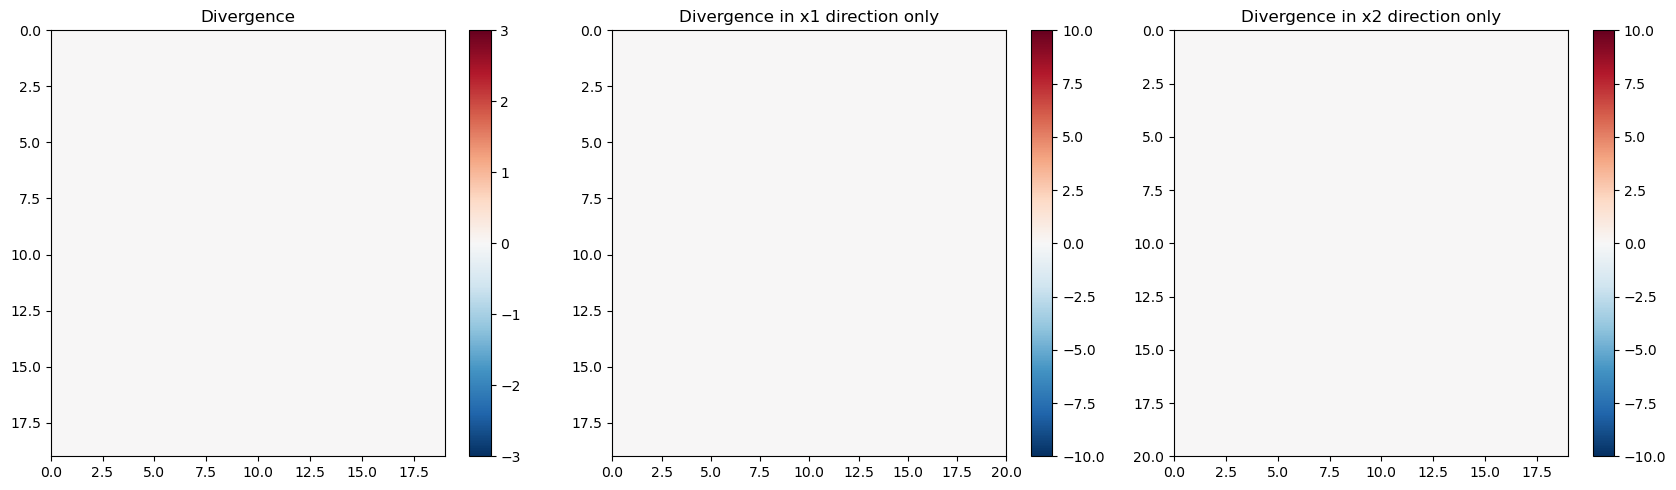

In [47]:
# Select columns 1 to last
Y2[:, 1:]
# Shifted to select the first to second last column
Y2[:, :-1]
# both are torch.Size([20, 19])

# Compare row 0 to row 1 and so on
grad_Y1_manual = (Y1[1:, :] - Y1[:-1, :]) / delta_x1
# Compare column 0 to column 1 and so on
grad_Y2_manual = (Y2[:, 1:] - Y2[:, :-1]) / delta_x2

div_manual = grad_Y1_manual[:19, :19] + grad_Y2_manual[:19, :19]
curl_manual = grad_Y2_manual[:19, :19] - grad_Y1_manual[:19, :19]

##### Plot #####

# Compute gradients (finite differences)
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 3
color_max = 10

# First subplot: Divergence in x1 direction
c1 = axs[0].pcolormesh(div_manual, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
# Invert y-axis to match tensor indexing
axs[0].invert_yaxis()
axs[0].set_title('Divergence')
fig.colorbar(c1, ax = axs[0])

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(grad_Y1_manual, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
axs[1].invert_yaxis()
axs[1].set_title('Divergence in x1 direction only')
fig.colorbar(c2, ax = axs[1])

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(grad_Y2_manual, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
axs[2].invert_yaxis()
axs[2].set_title('Divergence in x2 direction only')
fig.colorbar(c3, ax = axs[2])

"""
# Second subplot: Divergence in x2 direction
c4 = axs[3].pcolormesh(curl_manual, cmap = 'RdBu_r', vmin = - color_max -5, vmax = color_max+5)
axs[3].invert_yaxis()
axs[3].set_title('Curl')
fig.colorbar(c4, ax = axs[3])
"""

# Show the plot
plt.tight_layout()
plt.show()

### Torch does not do exactly the same as numpy

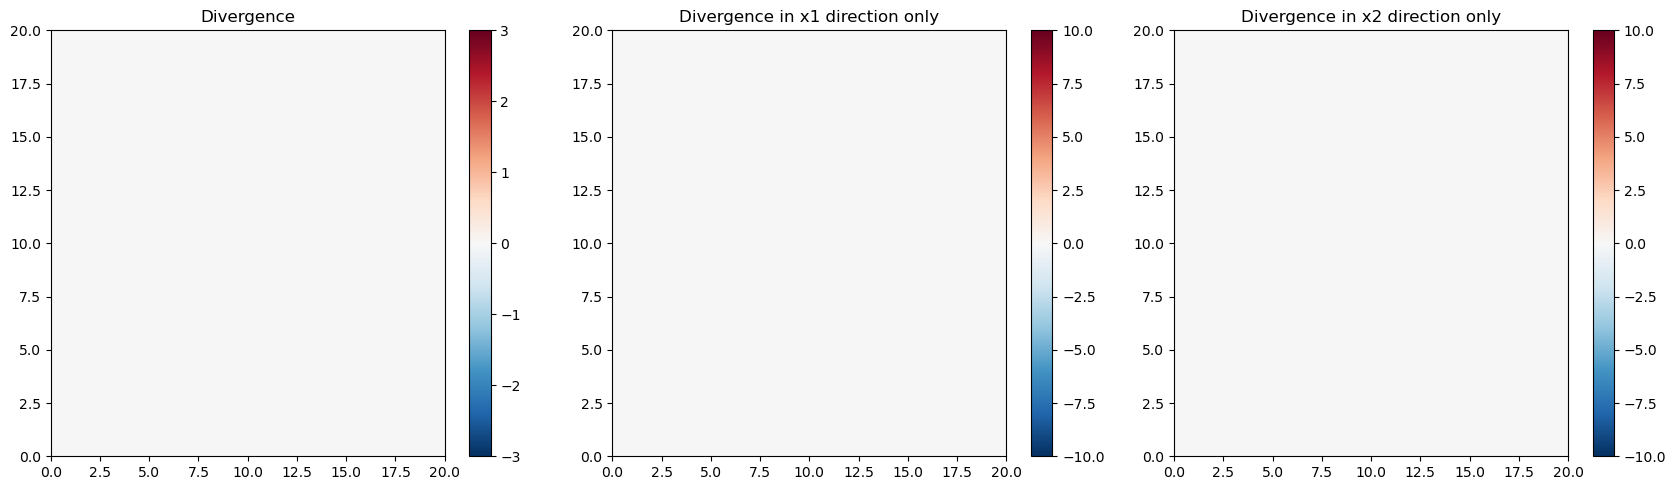

In [178]:
# Compute gradients (finite differences)
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 3
color_max = 10

# The last row can't be compared against anything - torch.Size([19, 20])
grad_Y1 = torch.diff(Y1, dim = 0) / delta_x1
torch_y1_gradient = torch.cat((grad_Y1, grad_Y1[-1, :].unsqueeze(0)), dim = 0)

# The last column can't be compared against anything - torch.Size([20, 19])
grad_Y2 = torch.diff(Y2, dim = 1) / delta_x2
# create copy of last column and append it to the right
torch_y2_gradient = torch.cat((grad_Y2, grad_Y2[:, -1].unsqueeze(1)), dim = 1)

torch_div = torch_y1_gradient + torch_y2_gradient

# First subplot: Divergence in x1 direction
c1 = axs[0].pcolormesh(torch_div, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
fig.colorbar(c1, ax = axs[0])
axs[0].set_title('Divergence')

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(torch_y1_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c2, ax = axs[1])
axs[1].set_title('Divergence in x1 direction only')

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(torch_y2_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c3, ax = axs[2])
axs[2].set_title('Divergence in x2 direction only')

# Show the plot
plt.tight_layout()
plt.show()

note copied rows/columns

# Numpy approach

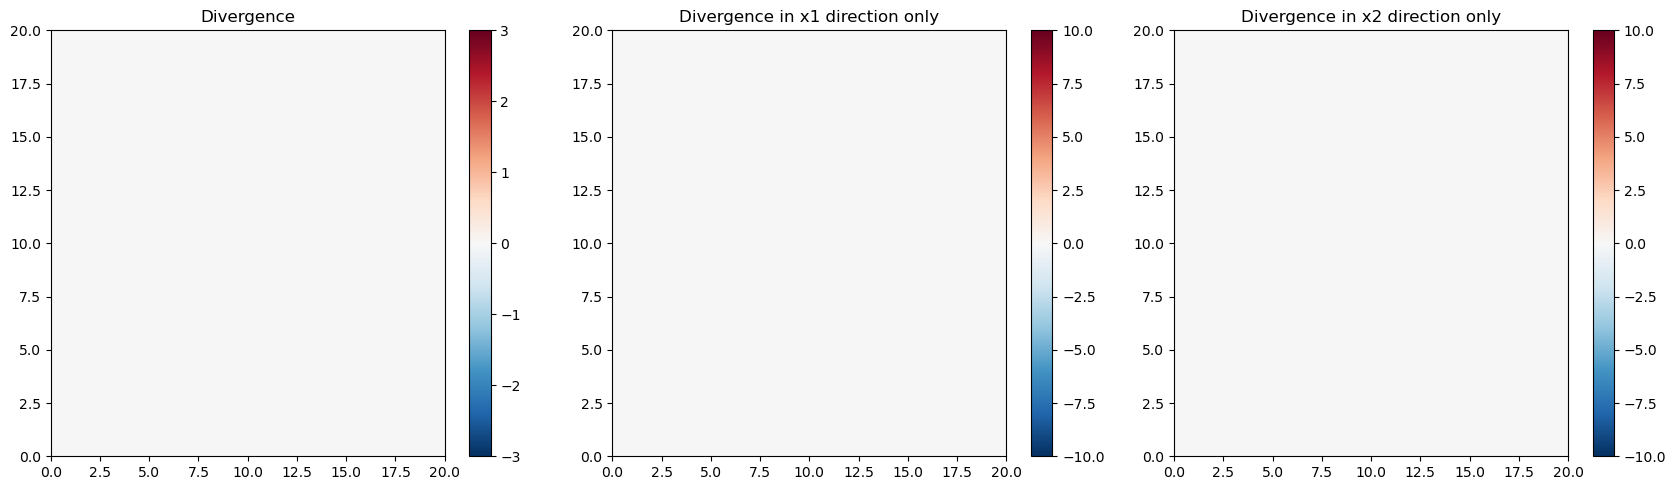

In [30]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize = (17, 5))

combined_color_max = 3
color_max = 10

numpy_y1_gradient = np.gradient(Y1, delta_x1, axis = 0)
# same as y1_gradient = np.gradient(Y1, 1, axis = 0) / delta_x1
numpy_y2_gradient = np.gradient(Y2, delta_x2, axis = 1)

numpy_div = numpy_y1_gradient + numpy_y2_gradient

# First subplot: Divergence in x1 direction
c1 = axs[0].pcolormesh(numpy_div, cmap = 'RdBu_r', vmin = - combined_color_max, vmax = combined_color_max)
fig.colorbar(c1, ax = axs[0])
axs[0].set_title('Divergence')

# First subplot: Divergence in x1 direction
c2 = axs[1].pcolormesh(numpy_y1_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c2, ax = axs[1])
axs[1].set_title('Divergence in x1 direction only')

# Second subplot: Divergence in x2 direction
c3 = axs[2].pcolormesh(numpy_y2_gradient, cmap = 'RdBu_r', vmin = - color_max, vmax = color_max)
fig.colorbar(c3, ax = axs[2])
axs[2].set_title('Divergence in x2 direction only')

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
# Numpy row zero is bottom row, torch row zero is top row
numpy_div[0, :]
# Numpy row -1 is top row, torch row -1 is bottom row
numpy_div[-1, :]

# Numpy column zero is leftmost column
numpy_div[:, 0]
# Numpy column -1 is rightmost column
numpy_div[:, -1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

# Fixed example

- only 5 data points
- to reproduce

In [48]:
sigma_n = torch.tensor([0.05])
# Flattenting the grid
X1_test = X1.reshape(-1, 1)
X2_test = X2.reshape(-1, 1)

In [49]:
# Capitalisation because this is artificially 2D data
X1_train_fixed = torch.tensor([0.1, 3.5, 0.6, 1.0, 2.0]).unsqueeze(-1)
X2_train_fixed = torch.tensor([0.1, 2.7, 3.9, 3.6, 1.4]).unsqueeze(-1)

# X1_train_fixed = torch.tensor([0.1, 3.5, 0.6, 1.0, 2.0, 1.5411, 3.9966, 1.7332, 0.5976, 2.4784, 3.1233, 2.2438, 2.3580, 1.3581, 2.8927]).unsqueeze(-1)
# X2_train_fixed = torch.tensor([0.1, 2.7, 3.9, 3.6, 1.4, 2.4040, 1.3802, 2.9802, 3.3997, 2.4960, 2.8871, 3.3554, 0.6658, 3.9083, 0.2392]).unsqueeze(-1)

X1_train_fixed = torch.tensor([3.5, 0.6, 1.0, 2.0, 1.5411, 3.9966, 1.7332, 0.5976, 2.4784, 3.1233, 2.2438, 2.3580, 1.3581, 2.8927]).unsqueeze(-1)
X2_train_fixed = torch.tensor([2.7, 3.9, 3.6, 1.4, 2.4040, 1.3802, 2.9802, 3.3997, 2.4960, 2.8871, 3.3554, 0.6658, 3.9083, 0.2392]).unsqueeze(-1)

# unsqueeze for explicit last dim - torch.Size([5, 1])
Y1_train_fixed_noisefree, Y2_train_fixed_noisefree = funnel_input_output_function(X1_train_fixed, X2_train_fixed)

# Add noise (small normal)
Y1_train_fixed_noisy = Y1_train_fixed_noisefree + torch.randn(Y1_train_fixed_noisefree.shape) * sigma_n
Y2_train_fixed_noisy = Y2_train_fixed_noisefree + torch.randn(Y2_train_fixed_noisefree.shape) * sigma_n

# Concatenate along the first axis so that first half is Y1 and second half is Y2
Y_train_fixed_noisy_flat = torch.cat((Y1_train_fixed_noisy, Y2_train_fixed_noisy), dim = 0)

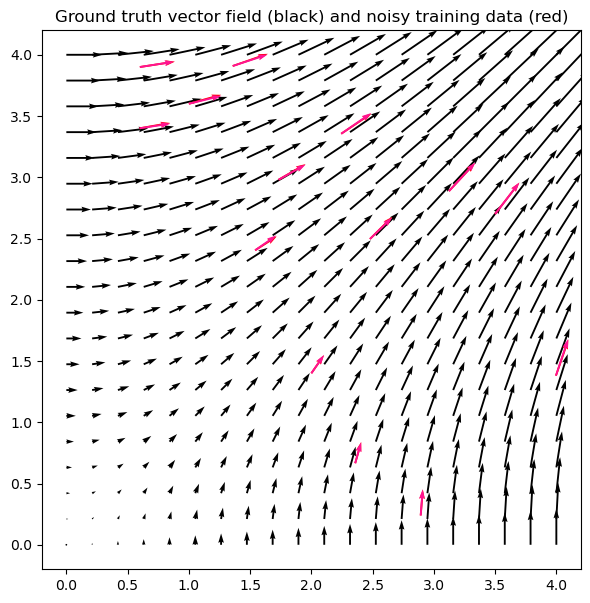

In [50]:
# Quiver plot paramaters are automatically adjusted and thus differ for both layers so we unify this
quiver_width = 0.0035
quiver_scale = 60

# creating plot
fig, ax = plt.subplots(figsize = (7, 7))

# quiver plot visualises 2 in 1 
ax.quiver(X1, X2, Y1, Y2, width = quiver_width, scale = quiver_scale)
ax.quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisefree, Y2_train_fixed_noisefree, color = 'red', width = quiver_width, scale = quiver_scale)
ax.quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisy, Y2_train_fixed_noisy, color = 'deeppink', width = quiver_width, scale = quiver_scale)

ax.set_aspect('equal')
plt.title('Ground truth vector field (black) and noisy training data (red)')
 
# show plot
plt.show()

Note on distance calculation:
- typically we use the Euclidean norm (i.e. the l2-norm)
- torch.cdist() calculates the p-norm with p = 2, which is equivalent to the l2-norm i.e. the Euclidean norm.
- however we treat all dimensions separetly
- For some reason the matlab implementations does not use the absolute value, but keeps +/-

In [60]:
lengthscale = torch.tensor([0.4])

def divergence_free_se_kernel(X1_rows, X2_rows, X1_columns, X2_columns, 
                              sigma_f = torch.tensor([0.7]), l = lengthscale):
    # Calculate the Euclidean distance between all pairs of points
    # previous approach yielded negative values as well, as dist was not squared
    # torch.Size([n_train, n_test])
    X1_dist = torch.cdist(X1_rows, X1_columns)
    # torch.Size([n_train, n_test])
    X2_dist = torch.cdist(X2_rows, X2_columns)

    # torch.Size([n_train, n_test])
    upper_left = (1 - X2_dist.square().div(l**2)).div(l**2)

    # elementwise multiplication and division by scalar
    # Matlab version has negative values here! 
    upper_right = torch.mul(X1_dist, X2_dist).div(l**4)
    lower_left = upper_right
    lower_right = (1 - X1_dist.square().div(l**2)).div(l**2)

    # Concatenate upper and lower blocks columnswise, and then concatenate them rowwise
    # torch.Size([2 * n_train, 2 * n_test])
    block = torch.cat((torch.cat((upper_left, upper_right), 1), torch.cat((lower_left, lower_right), 1)), 0)

    # torch.Size([2 * n_train, 2 * n_test])
    # elementwise multiplication
    K = sigma_f.square() * block.mul((X1_dist.square() + X2_dist.square()).div(-2 * l**2).exp().tile(2, 2))

    return K

In [86]:
lengthscale = torch.tensor([1.0])

# Change this to the difference
def divergence_free_se_kernel(X1_rows, X2_rows, X1_columns, X2_columns, 
                              sigma_f = torch.tensor([0.7]), l = lengthscale):
    # Calculate the Euclidean distance between all pairs of points
    # previous approach yielded negative values as well
    # torch.Size([n_train, n_test])
    X1_dist = (X1_rows.unsqueeze(1) - X1_columns.unsqueeze(0)).squeeze()
    print(X1_dist.shape)
    # torch.Size([n_train, n_test])
    X2_dist = (X2_rows.unsqueeze(1) - X2_columns.unsqueeze(0)).squeeze()
    print(X2_dist.shape)

    # torch.Size([n_train, n_test])
    upper_left = (1 - X2_dist.square().div(l**2)).div(l**2)

    # elementwise multiplication and division by scalar
    # Matlab version has negative values here! 
    upper_right = torch.mul(X1_dist, X2_dist).div(l**4)
    lower_left = upper_right
    lower_right = (1 - X1_dist.square().div(l**2)).div(l**2)

    # Concatenate upper and lower blocks columnswise, and then concatenate them rowwise
    # torch.Size([2 * n_train, 2 * n_test])
    block = torch.cat((torch.cat((upper_left, upper_right), 1), torch.cat((lower_left, lower_right), 1)), 0)

    # torch.Size([2 * n_train, 2 * n_test])
    # elementwise multiplication
    K = sigma_f.square() * block.mul((X1_dist.square() + X2_dist.square()).div(-2 * l**2).exp().tile(2, 2))

    return K

In [87]:
K_train_train = divergence_free_se_kernel(
    X1_train_fixed, 
    X2_train_fixed, 
    X1_train_fixed, 
    X2_train_fixed)

# Add noise to the diagonal
K_train_train_noisy = K_train_train + torch.eye(K_train_train.shape[0]) * sigma_n**2

# torch.Size([2 * n_train, 2 * n_test])
# K_* in Rasmussen is (X_train, X_test)
K_train_test = divergence_free_se_kernel(
    X1_train_fixed, 
    X2_train_fixed, 
    X1_test, 
    X2_test)

# torch.Size([2 * n_test, 2 * n_train])
K_test_train = K_train_test.mT

K_test_test = divergence_free_se_kernel(
    X1_test, 
    X2_test, 
    X1_test, 
    X2_test)

torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 400])
torch.Size([14, 400])
torch.Size([400, 400])
torch.Size([400, 400])


In [88]:
# K_test_test is psd

In [89]:
# print(torch.linalg.eigvalsh(K_test_test))

In [90]:
# Determine L - torch.Size([2 * n_train, 2 * n_train])
L = torch.linalg.cholesky(K_train_train_noisy, upper = False)
# L.T \ (L \ y) in one step - torch.Size([2 * n_train, 1])
alpha = torch.cholesky_solve(Y_train_fixed_noisy_flat, L, upper = False)

# matrix multiplication
# torch.Size([2 * n_test, 2 * n_train]) * torch.Size([2 * n_train, 1])
predictive_mean = torch.matmul(K_test_train, alpha)
predictive_mean_y1 = predictive_mean[:int(predictive_mean.shape[0]/2)].reshape(N_x, N_x)
predictive_mean_y2 = predictive_mean[int(predictive_mean.shape[0]/2):].reshape(N_x, N_x)

# Step 3: Solve for V = L^-1 * K(X_*, X)
# K_* is K_train_test
# L is lower triangular
v = torch.linalg.solve_triangular(L, K_train_test, upper = False)
# same as
# v = torch.linalg.solve(L, K_train_test)
# torch.matmul(v, v.T) would give the wrong shape
predictive_covariance = K_test_test - torch.matmul(v.T, v)

# Extract variance from diagonal for either dim and reshape into square grid
predictive_variance_y1 = torch.diagonal(predictive_covariance)[:int(predictive_covariance.shape[0]/2)].reshape(N_x, N_x)
predictive_variance_y2 = torch.diagonal(predictive_covariance)[int(predictive_covariance.shape[0]/2):].reshape(N_x, N_x)

# Negative Log Marginal Likelihood (NLML)

- 2.30 in Rasmussen
- https://d2l.ai/chapter_gaussian-processes/gp-inference.html

In [91]:
# matmul: torch.Size([1, 10]) * torch.Size([10, 1])
# 0.5 * y^T * alpha
lml_term1 = 0.5 * torch.matmul(Y_train_fixed_noisy_flat.T, alpha)

# sum(log(L_ii)))
lml_term2 = torch.sum(torch.log(torch.diagonal(L)))

# Constant term - technically not optimised 
# n/2 * log(2 * pi)
lml_term3 = (Y_train_fixed_noisy_flat.shape[0]/2) * torch.log(torch.tensor(2 * math.pi))

lml = - lml_term1 - lml_term2 - lml_term3
print(lml.squeeze())

tensor(-212.8198)


## Sample from posterior

In [92]:
K = predictive_covariance
# print(torch.linalg.eigvalsh(K))

# Symmetry check
is_symmetric = torch.allclose(K, K.T, atol=1e-6)

# Check for positive definiteness using eigenvalues
eigenvalues = torch.linalg.eigvalsh(K)
is_positive_definite = torch.all(eigenvalues > 0.0)

print(f"Is Symmetric: {is_symmetric}")
print(f"Is Positive Definite: {is_positive_definite}")

Is Symmetric: True
Is Positive Definite: False


In [93]:
n_samples = 4

predictive_covariance_jitter = predictive_covariance + 1e-5 * torch.eye(predictive_covariance.shape[0])
# predictive_covariance_jittery = predictive_covariance + (torch.eye(predictive_covariance.shape[0]) * torch.absolute(torch.min(torch.linalg.eigvalsh(predictive_covariance), torch.tensor(0.0))) * 1)
z = torch.randn(n_samples, predictive_mean.shape[0])
L_predictive = torch.linalg.cholesky(predictive_covariance_jitter, upper = False)

samples = predictive_mean.tile(1, n_samples).mT + torch.matmul(z, L_predictive.mT)

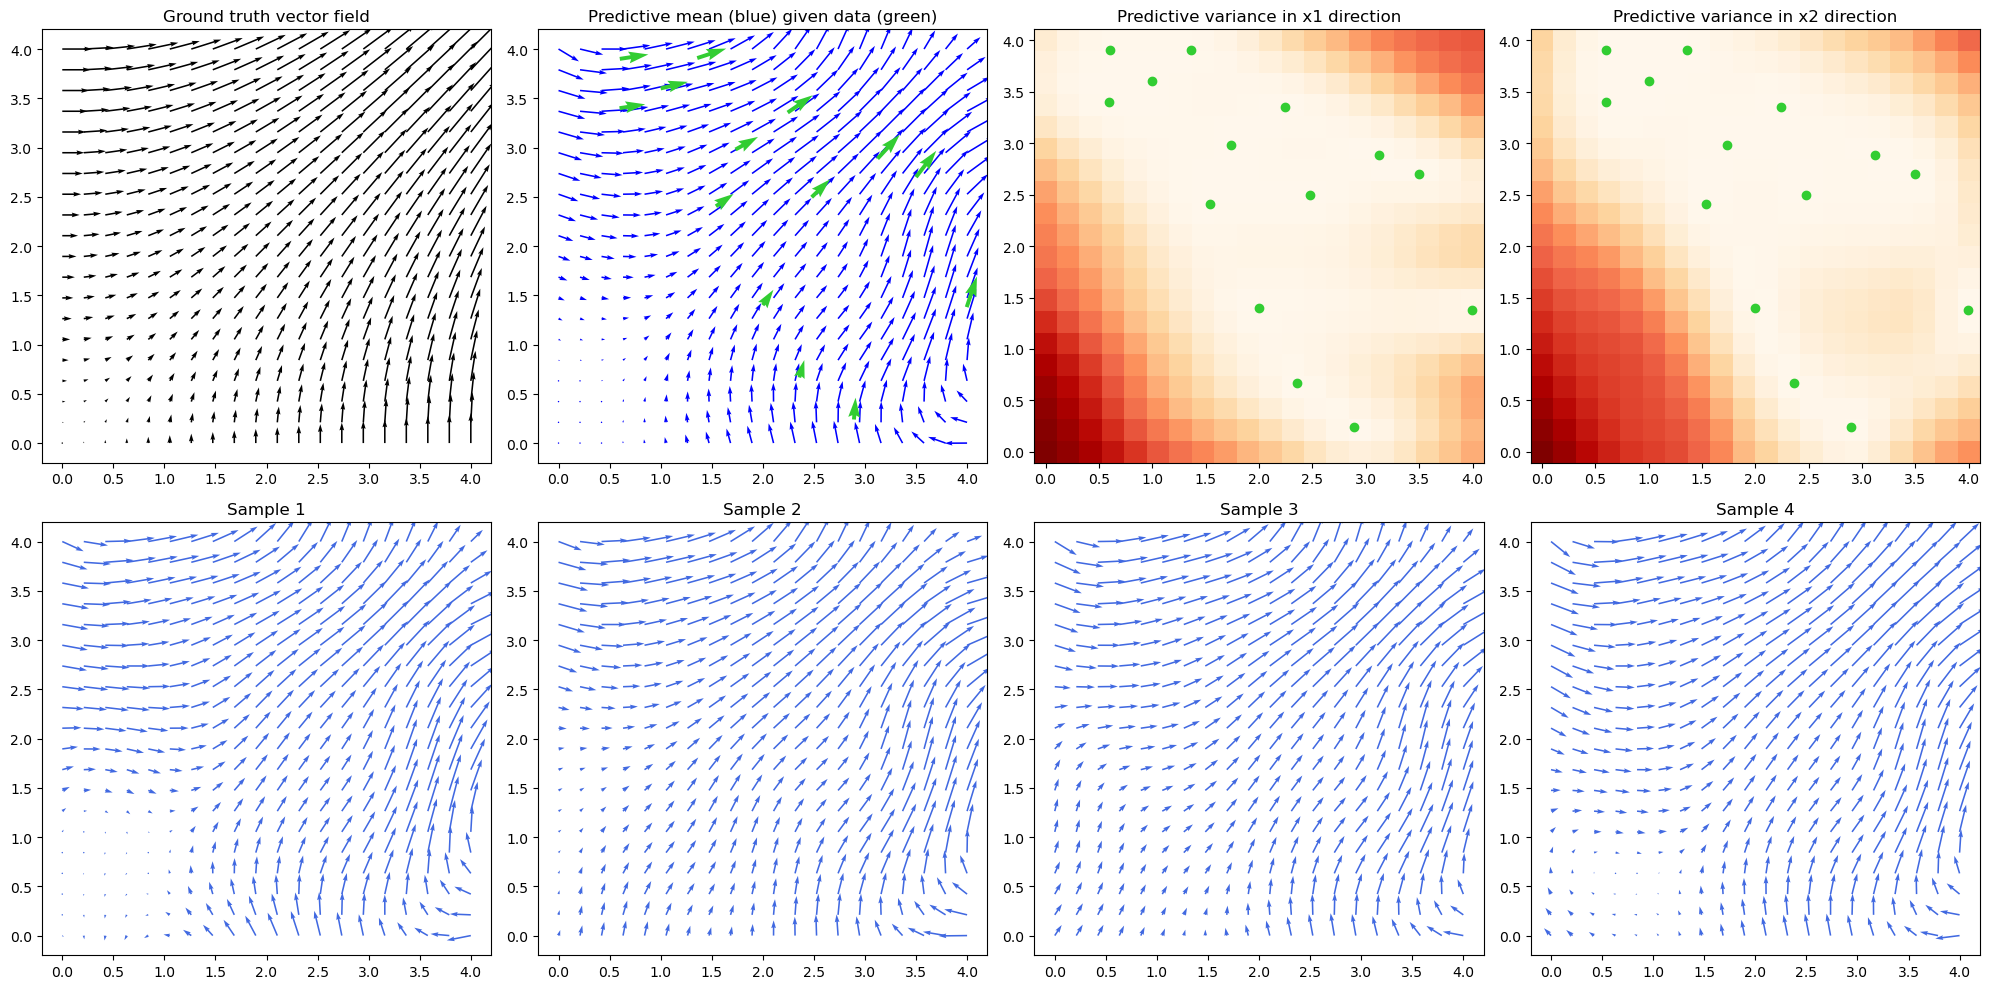

In [ ]:
fig, axs = plt.subplots(2, 4, figsize = (20, 10))

quiver_width = 0.0035
quiver_scale = 60

c1 = axs[0, 0].quiver(X1, X2, Y1, Y2, color = 'black', width = quiver_width, scale = quiver_scale)
axs[0, 0].set_title('Ground truth vector field')

c2 = axs[0, 1].quiver(X1, X2, predictive_mean_y1, predictive_mean_y2, color = 'blue', width = quiver_width, scale = quiver_scale)
c2 = axs[0, 1].quiver(X1_train_fixed, X2_train_fixed, Y1_train_fixed_noisy, Y2_train_fixed_noisy, color = 'limegreen', width = quiver_width * 2.5, scale = quiver_scale)
axs[0, 1].set_title('Predictive mean (blue) given data (green)')

c3 = axs[0, 2].pcolormesh(X1, X2, predictive_variance_y1, cmap = "OrRd")
axs[0, 2].scatter(X1_train_fixed, X2_train_fixed, color = 'limegreen')
axs[0, 2].set_title('Predictive variance in x1 direction')
# fig.colorbar(c3, ax = axs[0, 2])

c4 = axs[0, 3].pcolormesh(X1, X2, predictive_variance_y2, cmap = "OrRd")
axs[0, 3].scatter(X1_train_fixed, X2_train_fixed, color = 'limegreen')
axs[0, 3].set_title('Predictive variance in x2 direction')
# fig.colorbar(c4, ax = axs[0, 3])

# Second subplot: Divergence in x2 direction
c5 = axs[1, 0].quiver(X1, X2, samples[0][:400].reshape(N_x, N_x), samples[0][400:].reshape(N_x, N_x), color = 'royalblue', width = quiver_width, scale = quiver_scale)
axs[1, 0].set_title('Sample 1')

c6 = axs[1, 1].quiver(X1, X2, samples[1][:400].reshape(N_x, N_x), samples[1][400:].reshape(N_x, N_x), color = 'royalblue', width = quiver_width, scale = quiver_scale)
axs[1, 1].set_title('Sample 2')

c7 = axs[1, 2].quiver(X1, X2, samples[2][:400].reshape(N_x, N_x), samples[2][400:].reshape(N_x, N_x), color = 'royalblue', width = quiver_width, scale = quiver_scale)
axs[1, 2].set_title('Sample 3')

c8 = axs[1, 3].quiver(X1, X2, samples[3][:400].reshape(N_x, N_x), samples[3][400:].reshape(N_x, N_x), color = 'royalblue', width = quiver_width, scale = quiver_scale)
axs[1, 3].set_title('Sample 4')

# Show the plot
plt.tight_layout()
plt.show()

In [95]:
samples

tensor([[ 2.8539,  3.3704,  3.5583,  ...,  0.9953,  0.1129, -0.6350],
        [ 3.1083,  3.7195,  3.9467,  ...,  1.5931,  0.7373, -0.0468],
        [ 2.9337,  3.4905,  3.6083,  ...,  1.9871,  1.2480,  0.5304],
        [ 2.5633,  3.3327,  3.7051,  ...,  1.4389,  0.4928, -0.4005]])